In [ ]:
#By Srikar Vedula
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import sklearn
from google.colab import files
import io
inputFile = files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving beacon_data.csv to beacon_data.csv


In [ ]:
data = pd.read_csv(io.BytesIO(inputFile["beacon_data.csv"]),sep = ';') #read the .csv file
data.head()

,id,gtid,vendor_id,subscriber_id,merchant_id,signal_type,entry_date,exit_date,latitude,longitude,dongle_id,distance,proximity,rssi
0,2339839562,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2133,2,2017-05-01 09:54:14.000000,NaN,40.992124,29.126770,5536,-100.000000,unknown,0.0
1,2340151194,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
2,2340151210,5563AB7A-C5B0-492D-80E5-04E52A5C0C28,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
3,2340151187,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
4,2340185826,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2133,2,2017-05-01 10:32:19.000000,NaN,40.992110,29.126783,5536,1467.799268,far,-85.0


In [ ]:
#Drop columns that are irrelevant to the problem
dataset=data.drop(['gtid','dongle_id','id','merchant_id'],axis=1)
dataset.head(10)


,vendor_id,subscriber_id,signal_type,entry_date,exit_date,latitude,longitude,distance,proximity,rssi
0,135,29253903,2,2017-05-01 09:54:14.000000,NaN,40.992124,29.126770,-100.000000,unknown,0.0
1,135,17090954,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,1668.100537,far,-86.0
2,135,17090954,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,1668.100537,far,-86.0
3,178,15630196,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,1668.100537,far,-86.0
4,178,15630196,2,2017-05-01 10:32:19.000000,NaN,40.992110,29.126783,1467.799268,far,-85.0
5,135,17090954,2,2017-05-01 10:33:24.000000,NaN,40.992189,29.126786,1042.299640,far,-83.0
6,178,15630196,2,2017-05-01 10:33:25.000000,NaN,40.992189,29.126786,1467.799268,far,-85.0
7,110,12344705,2,2017-05-01 10:31:46.000000,NaN,40.992170,29.126774,1469.427280,far,-86.0
8,135,29449176,2,2017-05-01 10:38:31.000000,NaN,40.992110,29.126793,-100.000000,unknown,0.0
9,178,14977149,2,2017-05-01 10:38:30.000000,NaN,40.992110,29.126793,-100.000000,unknown,0.0


In [ ]:
dataset.shape

(125250, 10)

In [ ]:
#Check for nans
for column in dataset:
  print(column +' '+str(sum(data[column].isnull())))

vendor_id 0
subscriber_id 0
signal_type 0
entry_date 0
exit_date 109285
latitude 971
longitude 971
distance 15965
proximity 15965
rssi 15965


In [ ]:
#if more than 80% of the values in exit date column is nan, then drop that column
exit_nan=sum(dataset['exit_date'].isnull())
print("Count of Nans in Exit Date column",exit_nan)
row_len=dataset.shape[0]
print("Total count of exit date column",row_len)
print(float(exit_nan)/row_len)
if float(exit_nan)/row_len > 0.8:
  dataset=dataset.drop(['exit_date'],axis=1)


Count of Nans in Exit Date column 109285
Total count of exit date column 125250
0.8725349301397206


In [ ]:
dataset

,vendor_id,subscriber_id,signal_type,entry_date,latitude,longitude,distance,proximity,rssi
0,135,29253903,2,2017-05-01 09:54:14.000000,40.992124,29.126770,-100.000000,unknown,0.0
1,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
2,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
3,178,15630196,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
4,178,15630196,2,2017-05-01 10:32:19.000000,40.992110,29.126783,1467.799268,far,-85.0
...,...,...,...,...,...,...,...,...,...
125245,6,35404031,2,2017-09-19 21:27:36.000000,40.992169,29.126772,2782.559402,far,-90.0
125246,407,29038394,4,2017-09-19 21:54:42.000000,40.992083,29.126784,NaN,NaN,NaN
125247,407,29038394,2,2017-09-19 21:57:36.000000,40.992026,29.127078,1467.799268,far,-85.0
125248,407,29038394,4,2017-09-19 22:08:53.000000,40.999952,29.131801,NaN,NaN,NaN


In [ ]:
dataset=dataset.dropna(axis=0,how='any')

In [ ]:
dataset

,vendor_id,subscriber_id,signal_type,entry_date,latitude,longitude,distance,proximity,rssi
0,135,29253903,2,2017-05-01 09:54:14.000000,40.992124,29.126770,-100.000000,unknown,0.0
1,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
2,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
3,178,15630196,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far,-86.0
4,178,15630196,2,2017-05-01 10:32:19.000000,40.992110,29.126783,1467.799268,far,-85.0
...,...,...,...,...,...,...,...,...,...
125243,6,35404031,2,2017-09-19 21:21:10.000000,40.992161,29.126744,2782.559402,far,-90.0
125244,6,35404031,2,2017-09-19 21:25:21.000000,40.991731,29.126530,3593.813664,far,-92.0
125245,6,35404031,2,2017-09-19 21:27:36.000000,40.992169,29.126772,2782.559402,far,-90.0
125247,407,29038394,2,2017-09-19 21:57:36.000000,40.992026,29.127078,1467.799268,far,-85.0


In [ ]:
def data_preprocess(dataset,outputfile):
  dataset[dataset['proximity']=='far'].shape
  #Get average distance of values positive
  distance_avg=dataset[dataset['distance']>0]['distance'].mean()
  dataset.loc[dataset['distance']<0.0, 'distance']=distance_avg
  #Get average latitude and logitude excluding the 0 and then replacing the 0s with the average 
  latitude_avg=dataset[dataset['latitude']!=0]['latitude'].mean()
  print(latitude_avg)
  latitude_std=dataset[dataset['latitude']!=0]['latitude'].std()
  print(latitude_std)
  dataset.loc[dataset['latitude']==0.0, 'latitude']=latitude_avg

  longitude_avg=dataset[dataset['longitude']!=0]['longitude'].mean()
  print(longitude_avg)
  longitude_std=dataset[dataset['longitude']!=0]['longitude'].std()
  print(longitude_std)
  dataset.loc[dataset['longitude']==0.0, 'longitude']=longitude_avg
  # Normalize the latitude, longitude, rssi and distance columns by subtracting each row with the mean and dividing by standard deviation so as to make training models easier
  dataset.loc[:, 'longitude'] = (np.asarray(dataset['longitude'])-dataset['longitude'].mean())/dataset['longitude'].std()
  dataset.loc[:, 'latitude'] = (np.asarray(dataset['latitude'])-dataset['latitude'].mean())/dataset['latitude'].std()

  rssi_avg=dataset['rssi'].mean()
  print(rssi_avg)
  rssi_std=dataset['rssi'].std()
  print(rssi_std)

  dataset.loc[:, 'rssi'] = (np.asarray(dataset['rssi'])-dataset['rssi'].mean())/dataset['rssi'].std()
  dataset.loc[:, 'distance'] = (np.asarray(dataset['distance'])-dataset['distance'].mean())/dataset['distance'].std()

# Split up the entry date into year, month, day and day of week columns.
  dataset['new_entry_date'] = pd.to_datetime(dataset['entry_date'])
  dataset['new_entry_year']  = dataset['new_entry_date'].dt.year 
  dataset['new_entry_month'] = dataset['new_entry_date'].dt.month
  dataset['new_entry_day']   = dataset['new_entry_date'].dt.day
  dataset['weekday'] = dataset['new_entry_date'].dt.dayofweek

  dataset=dataset.drop(['entry_date'],axis=1)

  dataset.to_csv(outputfile)

In [ ]:
data_preprocess(dataset,'beacon_data_prepared_clean.csv')
#read preprocessed csv file
df=pd.read_csv('beacon_data_prepared_clean.csv',header=0, index_col=0)
#Display the data
df.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

40.99390550542402
0.01594577568874996
29.124276342908132
0.019330570579731
-70.51611840600265
33.81540960149131


,vendor_id,subscriber_id,signal_type,latitude,longitude,distance,proximity,rssi,new_entry_date,new_entry_year,new_entry_month,new_entry_day,weekday
0,135,29253903,2,-0.111741,0.129023,5.641250e-14,unknown,2.085325,2017-05-01 09:54:14,2017,5,1,0
1,135,17090954,2,-0.108040,0.128557,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
2,135,17090954,2,-0.108040,0.128557,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
3,178,15630196,2,-0.108040,0.128557,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
4,178,15630196,2,-0.112619,0.129695,-2.450340e-01,far,-0.428322,2017-05-01 10:32:19,2017,5,1,0
5,135,17090954,2,-0.107664,0.129850,-6.220644e-01,far,-0.369177,2017-05-01 10:33:24,2017,5,1,0
6,178,15630196,2,-0.107664,0.129850,-2.450340e-01,far,-0.428322,2017-05-01 10:33:25,2017,5,1,0
7,110,12344705,2,-0.108856,0.129230,-2.435914e-01,far,-0.457894,2017-05-01 10:31:46,2017,5,1,0
8,135,29449176,2,-0.112619,0.130213,5.641250e-14,unknown,2.085325,2017-05-01 10:38:31,2017,5,1,0
9,178,14977149,2,-0.112619,0.130213,5.641250e-14,unknown,2.085325,2017-05-01 10:38:30,2017,5,1,0


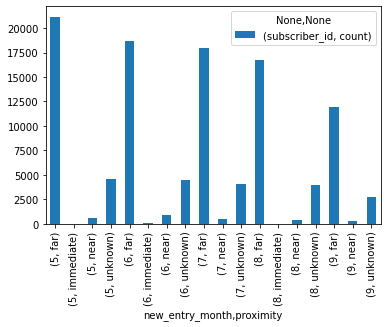

In [ ]:
#grouped=df["new_entry_year"] + df["new_entry_month"] + df["new_entry_day"]
grouped = df.groupby(['new_entry_month','proximity']).agg({"subscriber_id":['count']})
grouped.plot(kind='bar')

(7, 'immediate')
(9, 'immediate')


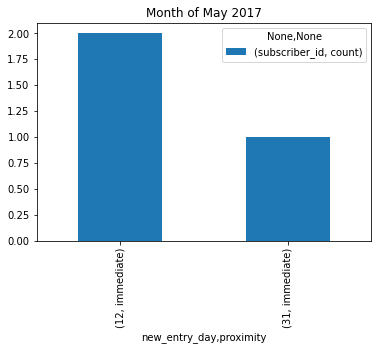

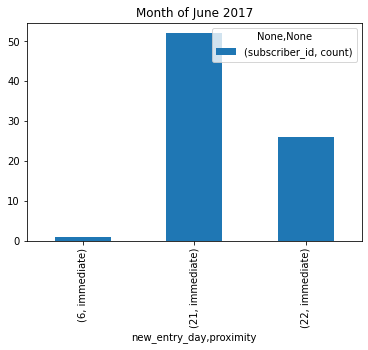

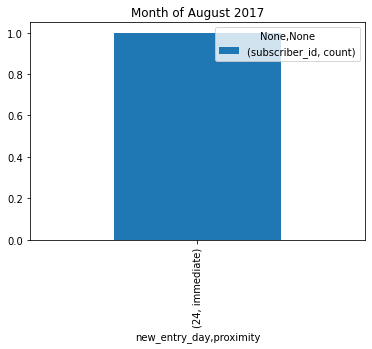

In [ ]:
#View the immediate count by each day for each month
grouped1=df.groupby(['new_entry_month','proximity'])
try:
  grouped5=grouped1.get_group((5, 'immediate'))
  grouped5=grouped5.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
  grouped5.plot(kind='bar',title='Month of May 2017')
except KeyError as e:
  print(e)

try:
  grouped6=grouped1.get_group((6, 'immediate'))
  grouped6=grouped6.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
  grouped6.plot(kind='bar',title='Month of June 2017')
except KeyError as e:
  print(e)

try:
  grouped7=grouped1.get_group((7, 'immediate'))
  grouped7=grouped7.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
  grouped7.plot(kind='bar',title='Month of July 2017')
except KeyError as e:
  print(e)
try:  
  grouped8=grouped1.get_group((8, 'immediate'))
  grouped8=grouped8.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
  grouped8.plot(kind='bar',title='Month of August 2017')
except KeyError as e:
  print(e)
try:
  grouped9=grouped1.get_group((9, 'immediate'))
  grouped9=grouped9.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
  grouped9.plot(kind='bar',title='Month of September 2017')
except KeyError as e:
  print(e)

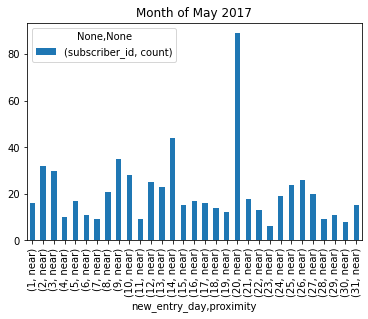

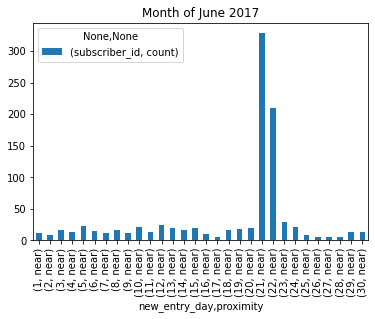

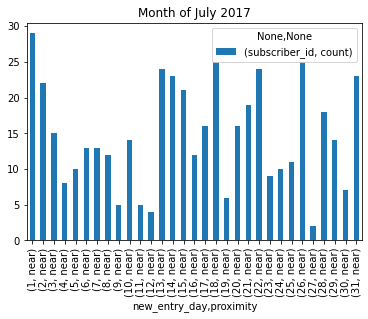

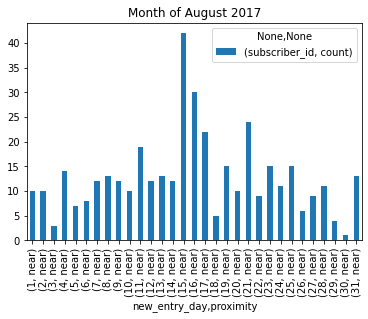

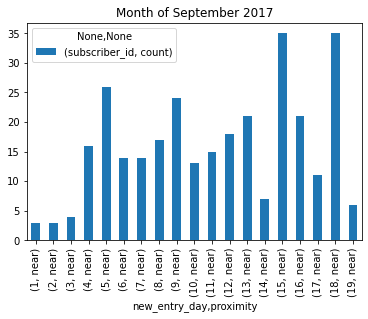

In [ ]:
#View the near count by each day for each month
grouped1=df.groupby(['new_entry_month','proximity'])

grouped5=grouped1.get_group((5, 'near'))
grouped5=grouped5.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
grouped5.plot(kind='bar',title='Month of May 2017')
grouped6=grouped1.get_group((6, 'near'))
grouped6=grouped6.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
grouped6.plot(kind='bar',title='Month of June 2017')
grouped7=grouped1.get_group((7, 'near'))
grouped7=grouped7.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
grouped7.plot(kind='bar',title='Month of July 2017')
grouped8=grouped1.get_group((8, 'near'))
grouped8=grouped8.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
grouped8.plot(kind='bar',title='Month of August 2017')
grouped9=grouped1.get_group((9, 'near'))
grouped9=grouped9.groupby(['new_entry_day','proximity']).agg({"subscriber_id":['count']})
grouped9.plot(kind='bar',title='Month of September 2017')


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


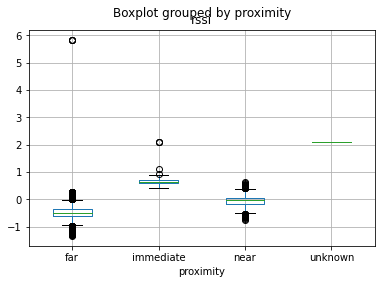

In [ ]:
df.boxplot(column = "rssi",by = "proximity")

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 2742.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 ,
        1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71,
        1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79

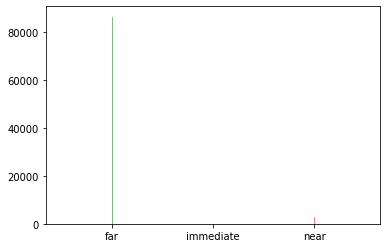

In [ ]:
x1 = df.loc[df['proximity']=='far', 'proximity']
x2 = df.loc[df['proximity']=='immediate', 'proximity']
x3 = df.loc[df['proximity']=='near', 'proximity']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='Ideal')
plt.hist(x2, **kwargs, color='b', label='Fair')
plt.hist(x3, **kwargs, color='r', label='Good')

In [ ]:
df=df.drop(['latitude','longitude'],axis=1)
df.head()

,vendor_id,subscriber_id,signal_type,distance,proximity,rssi,new_entry_date,new_entry_year,new_entry_month,new_entry_day,weekday
0,135,29253903,2,5.641250e-14,unknown,2.085325,2017-05-01 09:54:14,2017,5,1,0
1,135,17090954,2,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
2,135,17090954,2,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
3,178,15630196,2,-6.754933e-02,far,-0.457894,2017-05-01 10:28:45,2017,5,1,0
4,178,15630196,2,-2.450340e-01,far,-0.428322,2017-05-01 10:32:19,2017,5,1,0


In [ ]:
df=df.drop('rssi',axis=1)
df.head()

,vendor_id,subscriber_id,signal_type,distance,proximity,new_entry_date,new_entry_year,new_entry_month,new_entry_day,weekday
0,135,29253903,2,5.641250e-14,unknown,2017-05-01 09:54:14,2017,5,1,0
1,135,17090954,2,-6.754933e-02,far,2017-05-01 10:28:45,2017,5,1,0
2,135,17090954,2,-6.754933e-02,far,2017-05-01 10:28:45,2017,5,1,0
3,178,15630196,2,-6.754933e-02,far,2017-05-01 10:28:45,2017,5,1,0
4,178,15630196,2,-2.450340e-01,far,2017-05-01 10:32:19,2017,5,1,0


In [ ]:
df.weekday.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
df=df[df["proximity"] != "unknown"]

In [ ]:
df['DataFrame_Column'] = pd.to_datetime(df['new_entry_date'], format="%Y-%m-%d %H:%M:%S")
df=df.drop('new_entry_date',axis=1)
def week_of_month(date_value):
 return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
#df["month"]=df.DataFrame_Column.dt.strftime("%B")

df["week"] = [week_of_month(d) for d in df["DataFrame_Column"]]
df=df.drop('new_entry_day',axis=1)
df["day_entry_date"] = [d.date() for d in df["DataFrame_Column"]]
df["time_entry_date"] = [d.time() for d in df["DataFrame_Column"]]
df["day"] = [(d.weekday()+1) for d in df["DataFrame_Column"]] 
df["day"] = ['weekend' if d in ([6,7]) else 'weekday' for d in df["day"]]
df.head()


,vendor_id,subscriber_id,signal_type,distance,proximity,new_entry_year,new_entry_month,weekday,DataFrame_Column,week,day_entry_date,time_entry_date,day
1,135,17090954,2,-0.067549,far,2017,5,0,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
2,135,17090954,2,-0.067549,far,2017,5,0,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
3,178,15630196,2,-0.067549,far,2017,5,0,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
4,178,15630196,2,-0.245034,far,2017,5,0,2017-05-01 10:32:19,1,2017-05-01,10:32:19,weekday
5,135,17090954,2,-0.622064,far,2017,5,0,2017-05-01 10:33:24,1,2017-05-01,10:33:24,weekday


In [ ]:
df=df.drop('weekday',axis=1)
df.head()


,vendor_id,subscriber_id,signal_type,distance,proximity,new_entry_year,new_entry_month,DataFrame_Column,week,day_entry_date,time_entry_date,day
1,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
2,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
3,178,15630196,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
4,178,15630196,2,-0.245034,far,2017,5,2017-05-01 10:32:19,1,2017-05-01,10:32:19,weekday
5,135,17090954,2,-0.622064,far,2017,5,2017-05-01 10:33:24,1,2017-05-01,10:33:24,weekday


In [ ]:
time_x = df.loc[:,["vendor_id","subscriber_id","day_entry_date","DataFrame_Column","new_entry_month","day","week"]]

time_x = time_x.groupby(["vendor_id","subscriber_id","day_entry_date","new_entry_month","day","week"], as_index=False).DataFrame_Column.agg(['min','max']).reset_index()

time_x = time_x.rename(columns = {'min':'min_time','max':'max_time'})
time_x["dif_time_minutes"] = (time_x.max_time - time_x.min_time).dt.seconds/60 

time_x = time_x.drop(["subscriber_id","day_entry_date","min_time","max_time"], axis = 1) 

time_x=time_x.groupby(["vendor_id","new_entry_month","day","week"]).agg({"dif_time_minutes":"mean"}).rename(columns = {"dif_time_minutes":"mean_time_minutes"}).reset_index() 

time_x.head()

,vendor_id,new_entry_month,day,week,mean_time_minutes
0,6,5,weekday,1,16.943860
1,6,5,weekday,2,6.417857
2,6,5,weekday,3,7.925000
3,6,5,weekday,4,43.333333
4,6,5,weekday,5,32.194444


In [ ]:
df_x=pd.merge(df,time_x, how = "left", on =["vendor_id","new_entry_month","week","day"])
df_x.head()

,vendor_id,subscriber_id,signal_type,distance,proximity,new_entry_year,new_entry_month,DataFrame_Column,week,day_entry_date,time_entry_date,day,mean_time_minutes
0,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday,25.812319
1,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday,25.812319
2,178,15630196,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday,16.465217
3,178,15630196,2,-0.245034,far,2017,5,2017-05-01 10:32:19,1,2017-05-01,10:32:19,weekday,16.465217
4,135,17090954,2,-0.622064,far,2017,5,2017-05-01 10:33:24,1,2017-05-01,10:33:24,weekday,25.812319


In [ ]:
df_x=df_x.drop(['day_entry_date','time_entry_date','new_entry_year','DataFrame_Column','signal_type'],axis=1)
df_x.head()

,vendor_id,subscriber_id,distance,proximity,new_entry_month,week,day,mean_time_minutes
0,135,17090954,-0.067549,far,5,1,weekday,25.812319
1,135,17090954,-0.067549,far,5,1,weekday,25.812319
2,178,15630196,-0.067549,far,5,1,weekday,16.465217
3,178,15630196,-0.245034,far,5,1,weekday,16.465217
4,135,17090954,-0.622064,far,5,1,weekday,25.812319


In [ ]:
df_x["day_int"] = [1 if d =='weekday' else 2 for d in df_x["day"]]
df_x.head()
df_x=df_x.drop('day',axis=1)
df_x.head()

,vendor_id,subscriber_id,distance,proximity,new_entry_month,week,mean_time_minutes,day_int
0,135,17090954,-0.067549,far,5,1,25.812319,1
1,135,17090954,-0.067549,far,5,1,25.812319,1
2,178,15630196,-0.067549,far,5,1,16.465217,1
3,178,15630196,-0.245034,far,5,1,16.465217,1
4,135,17090954,-0.622064,far,5,1,25.812319,1


In [ ]:
  df_x.loc[:, 'vendor_id'] = (np.asarray(df_x['vendor_id'])-df_x['vendor_id'].mean())/df_x['vendor_id'].std()
  df_x.loc[:, 'new_entry_month'] = (np.asarray(df_x['new_entry_month'])-df_x['new_entry_month'].mean())/df_x['new_entry_month'].std()
  df_x.loc[:, 'week'] = (np.asarray(df_x['week'])-df_x['week'].mean())/df_x['week'].std()
  df_x.loc[:, 'day_int'] = (np.asarray(df_x['day_int'])-df_x['day_int'].mean())/df_x['day_int'].std()
  df_x.head()

,vendor_id,subscriber_id,distance,proximity,new_entry_month,week,mean_time_minutes,day_int
0,-0.364845,17090954,-0.067549,far,-1.282333,-1.561308,25.812319,-0.632137
1,-0.364845,17090954,-0.067549,far,-1.282333,-1.561308,25.812319,-0.632137
2,0.031749,15630196,-0.067549,far,-1.282333,-1.561308,16.465217,-0.632137
3,0.031749,15630196,-0.245034,far,-1.282333,-1.561308,16.465217,-0.632137
4,-0.364845,17090954,-0.622064,far,-1.282333,-1.561308,25.812319,-0.632137


In [ ]:
df_y=df_x[df_x["proximity"].isin(["immediate","near"])].loc[:,["vendor_id","subscriber_id","new_entry_month","week","day_int"]]

df_y=df_y.groupby(["vendor_id","new_entry_month","week","day_int"]).agg({"subscriber_id":pd.Series.nunique}).rename(columns = {"subscriber_id":"subscriber_unique"}).reset_index() #Unique per day

df_y=df_y.groupby(["vendor_id","new_entry_month","week","day_int"]).agg({"subscriber_unique":"sum"}).reset_index() #Then sum() the subscriber_unique. A customer could have transactions every day within the same week.

df_y.head()

,vendor_id,new_entry_month,week,day_int,subscriber_unique
0,-1.55463,-1.282333,-1.561308,-0.632137,1
1,-1.55463,-1.282333,-1.561308,1.581917,1
2,-1.55463,-1.282333,-0.757898,-0.632137,2
3,-1.55463,-1.282333,-0.757898,1.581917,1
4,-1.55463,-1.282333,0.045511,-0.632137,1


In [ ]:
final_df=pd.merge(df_x,df_y, how = "left", on =["vendor_id","new_entry_month","week","day_int"])
final_df=final_df.drop(['proximity','subscriber_id'],axis=1)
print(final_df.shape)
final_df=final_df.dropna(axis=0,how='any')
final_df.head()
final_df.shape

(89359, 7)


(76220, 7)

In [ ]:
X_train_tm = final_df.loc[:,:"day_int"]
y_train_tm = final_df.loc[:,"subscriber_unique"]
X_train_tm.head()

,vendor_id,distance,new_entry_month,week,mean_time_minutes,day_int
0,-0.364845,-0.067549,-1.282333,-1.561308,25.812319,-0.632137
1,-0.364845,-0.067549,-1.282333,-1.561308,25.812319,-0.632137
2,0.031749,-0.067549,-1.282333,-1.561308,16.465217,-0.632137
3,0.031749,-0.245034,-1.282333,-1.561308,16.465217,-0.632137
4,-0.364845,-0.622064,-1.282333,-1.561308,25.812319,-0.632137


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

y_train = (y_train_tm>1).astype(float) 
X_train, X_test, y_train, y_test = train_test_split(X_train_tm, y_train, test_size=0.3, random_state=1, stratify = y_train)

clf = svm.SVC(kernel = 'rbf', C = 1.0,class_weight='balanced') 

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

preds = clf.predict(X_test)
targs = y_test 
print("SVM MODEL:")
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("ROC AUC: ", metrics.roc_auc_score(targs, preds))

SVM MODEL:
accuracy:  0.5972623108545438
precision:  0.9631890492045875
recall:  0.5416905071521456
f1:  0.6934114592003197
ROC AUC:  0.7161899391020272


In [ ]:
#ARIMA

df.head()


,vendor_id,subscriber_id,signal_type,distance,proximity,new_entry_year,new_entry_month,DataFrame_Column,week,day_entry_date,time_entry_date,day
1,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
2,135,17090954,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
3,178,15630196,2,-0.067549,far,2017,5,2017-05-01 10:28:45,1,2017-05-01,10:28:45,weekday
4,178,15630196,2,-0.245034,far,2017,5,2017-05-01 10:32:19,1,2017-05-01,10:32:19,weekday
5,135,17090954,2,-0.622064,far,2017,5,2017-05-01 10:33:24,1,2017-05-01,10:33:24,weekday


In [ ]:
df1=df.drop(['new_entry_year','new_entry_month','DataFrame_Column','week','time_entry_date','signal_type'],axis=1)
df1["day_int"] = [1 if d =='weekday' else 2 for d in df1["day"]]
df1=df1.drop("day",axis=1)
df1.head()
df1["String_Entry_date"]=[x.strftime('%Y %m %d %H:%M:%S') for x in df1["day_entry_date"]]
df1.head()
df1["Entry_date"]=[pd.datetime.strptime(x, '%Y %m %d %H:%M:%S') for x in df1["String_Entry_date"]]
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


,vendor_id,subscriber_id,distance,proximity,day_entry_date,day_int,String_Entry_date,Entry_date
1,135,17090954,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
2,135,17090954,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
3,178,15630196,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
4,178,15630196,-0.245034,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
5,135,17090954,-0.622064,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01


In [ ]:
df1=df1[df1["proximity"].isin(["immediate","near"])].loc[:,["vendor_id","subscriber_id","distance","Entry_date","day_int"]]
df2=df1.groupby(["Entry_date"],as_index=False).agg({"subscriber_id":pd.Series.nunique,}).rename(columns = {"subscriber_id":"subscriber_unique"})
df2.head()

,Entry_date,subscriber_unique
0,2017-05-01,10
1,2017-05-02,12
2,2017-05-03,17
3,2017-05-04,8
4,2017-05-05,11


In [ ]:
df2.index = pd.DatetimeIndex(df2.Entry_date)
df2.head()

,Entry_date,subscriber_unique
Entry_date,,
2017-05-01,2017-05-01,10
2017-05-02,2017-05-02,12
2017-05-03,2017-05-03,17
2017-05-04,2017-05-04,8
2017-05-05,2017-05-05,11


In [ ]:
df2=df2.drop("Entry_date",axis=1)
df2.head()

,subscriber_unique
Entry_date,
2017-05-01,10
2017-05-02,12
2017-05-03,17
2017-05-04,8
2017-05-05,11


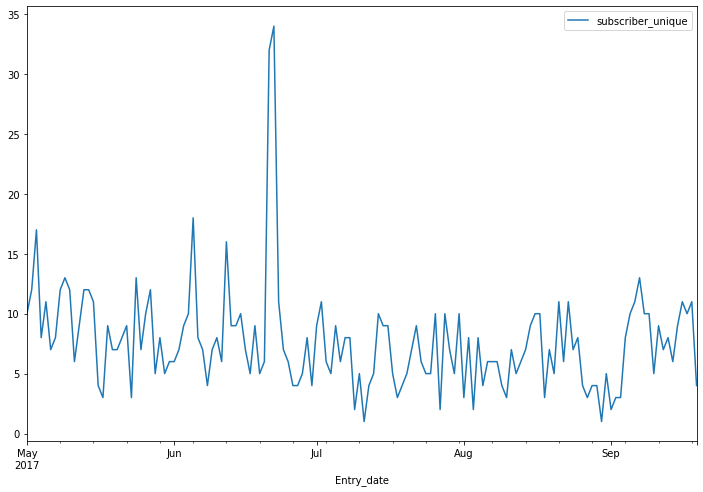

In [ ]:
df2.plot(figsize=(12,8));

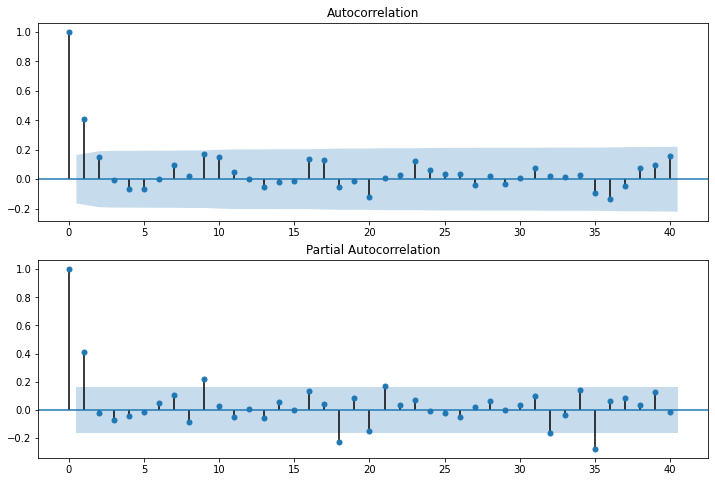

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2, lags=40, ax=ax2)

In [ ]:
df2.head()

print("Shape of df: ",df2.shape)
subscriber_avg=df2['subscriber_unique'].mean()
print("Mean: ",subscriber_avg)
subscriber_std=df2['subscriber_unique'].std()
print("STDEV: ",subscriber_std)

df2.loc[:, 'subscriber_unique_norm'] = (np.asarray(df2['subscriber_unique'])-df2['subscriber_unique'].mean())/df2['subscriber_unique'].std()
df2.head()
actual_subscriber=pd.DataFrame(df2.subscriber_unique)
df2=df2.drop('subscriber_unique',axis=1)
df2.head()
df2['lag']=df2['subscriber_unique_norm'].shift()
df2.dropna(inplace=True)
df2.head()
print("shape of actual scriber: ",actual_subscriber.shape)

#Training/Testing set
train=df2.iloc[:int(0.8*df2.shape[0]),:]
print("Train: ",train.shape)
test=df2.iloc[int(0.8*df2.shape[0])+1:,]
print("test: ",test.shape)
print("shape of actual scriber after: ",actual_subscriber.shape)

act_subscriber=actual_subscriber.iloc[int(0.8*actual_subscriber.shape[0])+1:,]

print(act_subscriber.shape)
model3=sm.tsa.ARIMA(endog=train['subscriber_unique_norm'],exog=train[['lag']],order=[1,1,0])
results3=model3.fit()
# # get various statstics related to training
print(results3.summary())
print(df2[["lag"]])
print("df[lag]: ",model3.predict(test['lag']))
print("df[lag]: after changes ",(model3.predict(test['lag'])*subscriber_std)+subscriber_avg)
predict_subscriber=(model3.predict(test['lag'])*subscriber_std)+subscriber_avg
print("Shape of test predict: ", predict_subscriber.shape)

Shape of df:  (142, 1)
Mean:  7.676056338028169
STDEV:  4.383316688113337
shape of actual scriber:  (142, 1)
Train:  (112, 2)
test:  (28, 2)
shape of actual scriber after:  (142, 1)
(28, 1)
                                ARIMA Model Results                                 
Dep. Variable:     D.subscriber_unique_norm   No. Observations:                  111
Model:                       ARIMA(1, 1, 0)   Log Likelihood                -154.287
Method:                             css-mle   S.D. of innovations              0.971
Date:                      Tue, 19 Jan 2021   AIC                            316.574
Time:                              04:23:27   BIC                            327.412
Sample:                          05-03-2017   HQIC                           320.971
                               - 08-21-2017                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
def mean_forecast_err(y, yhat):
    return np.linalg.norm(y-yhat).mean()
print("Testing error: ")
print(mean_forecast_err(np.asarray(act_subscriber[2:]), np.asarray(predict_subscriber[:act_subscriber.shape[0]])))
print("Testing error: ")
print(mean_forecast_err(np.asarray(train.lag.iloc[1:]), np.asarray(model3.predict(train['lag']))))

Testing error: 
108.10181173768945
Testing error: 
44.07294137998666


In [ ]:
#LSTM
df.head()
df1=df.drop(['new_entry_year','new_entry_month','DataFrame_Column','week','time_entry_date','signal_type'],axis=1)
df1["day_int"] = [1 if d =='weekday' else 2 for d in df1["day"]]
df1=df1.drop("day",axis=1)
df1.head()
df1["String_Entry_date"]=[x.strftime('%Y %m %d %H:%M:%S') for x in df1["day_entry_date"]]
df1.head()
df1["Entry_date"]=[pd.datetime.strptime(x, '%Y %m %d %H:%M:%S') for x in df1["String_Entry_date"]]
df1.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


,vendor_id,subscriber_id,distance,proximity,day_entry_date,day_int,String_Entry_date,Entry_date
1,135,17090954,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
2,135,17090954,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
3,178,15630196,-0.067549,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
4,178,15630196,-0.245034,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01
5,135,17090954,-0.622064,far,2017-05-01,1,2017 05 01 00:00:00,2017-05-01


In [ ]:
df1=df1[df1["proximity"].isin(["immediate","near"])].loc[:,["vendor_id","subscriber_id","distance","Entry_date","day_int"]]
df2=df1.groupby(["Entry_date"],as_index=False).agg({"subscriber_id":pd.Series.nunique,"distance":"mean","vendor_id":"mean","day_int":"mean"}).rename(columns = {"subscriber_id":"subscriber_unique"})
df2.head()
df2.loc[:, 'vendor_id'] = (np.asarray(df2['vendor_id'])-df2['vendor_id'].mean())/df2['vendor_id'].std()
df2.head()

,Entry_date,subscriber_unique,distance,vendor_id,day_int
0,2017-05-01,10,-1.313428,0.105033,1
1,2017-05-02,12,-1.294160,-1.210081,1
2,2017-05-03,17,-1.311969,-0.332727,1
3,2017-05-04,8,-1.341737,-0.612524,1
4,2017-05-05,11,-1.330916,0.355149,1


In [ ]:
def convert_timeseries(data, n_in=1, n_out=1, dropnan=True):
	#covert timeseries data to t-n to t-1 form
	#n defines how many previous value should be taken into consideration
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
reframed = convert_timeseries(df2, 2, 1)
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
2,2017-05-01,10.0,-1.313428,0.105033,1.0,2017-05-02,12.0,-1.294160,-1.210081,1.0,2017-05-03,17,-1.311969,-0.332727,1
3,2017-05-02,12.0,-1.294160,-1.210081,1.0,2017-05-03,17.0,-1.311969,-0.332727,1.0,2017-05-04,8,-1.341737,-0.612524,1
4,2017-05-03,17.0,-1.311969,-0.332727,1.0,2017-05-04,8.0,-1.341737,-0.612524,1.0,2017-05-05,11,-1.330916,0.355149,1
5,2017-05-04,8.0,-1.341737,-0.612524,1.0,2017-05-05,11.0,-1.330916,0.355149,1.0,2017-05-06,7,-1.217645,-0.104444,2
6,2017-05-05,11.0,-1.330916,0.355149,1.0,2017-05-06,7.0,-1.217645,-0.104444,2.0,2017-05-07,8,-1.310315,-0.456598,2


In [ ]:
values = reframed.values
values.shape
new_vals = values[:, [1,2,3,4,7,8,9,12,13,14]]
print(new_vals.shape)
output_val=values[:,11][:,None]
output_val
n_train = 98
train_X = new_vals[:n_train, :].astype('float32')
test_X = new_vals[n_train:, :].astype('float32')
train_y=output_val[:n_train, :].astype('float32')
test_y=output_val[n_train:, :].astype('float32')
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140, 10)
(98, 1, 10) (98, 1) (42, 1, 10) (42, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers

model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
sgd = optimizers.Adam(lr=1e-6)
model.compile(loss='mae', optimizer='adam')


Epoch 1/1000
3/3 - 2s - loss: 7.9692 - val_loss: 6.8862
Epoch 2/1000
3/3 - 0s - loss: 7.8881 - val_loss: 6.8095
Epoch 3/1000
3/3 - 0s - loss: 7.8068 - val_loss: 6.7320
Epoch 4/1000
3/3 - 0s - loss: 7.7248 - val_loss: 6.6537
Epoch 5/1000
3/3 - 0s - loss: 7.6420 - val_loss: 6.5746
Epoch 6/1000
3/3 - 0s - loss: 7.5586 - val_loss: 6.4947
Epoch 7/1000
3/3 - 0s - loss: 7.4743 - val_loss: 6.4139
Epoch 8/1000
3/3 - 0s - loss: 7.3893 - val_loss: 6.3321
Epoch 9/1000
3/3 - 0s - loss: 7.3034 - val_loss: 6.2491
Epoch 10/1000
3/3 - 0s - loss: 7.2164 - val_loss: 6.1649
Epoch 11/1000
3/3 - 0s - loss: 7.1283 - val_loss: 6.0793
Epoch 12/1000
3/3 - 0s - loss: 7.0389 - val_loss: 5.9922
Epoch 13/1000
3/3 - 0s - loss: 6.9482 - val_loss: 5.9035
Epoch 14/1000
3/3 - 0s - loss: 6.8561 - val_loss: 5.8134
Epoch 15/1000
3/3 - 0s - loss: 6.7626 - val_loss: 5.7218
Epoch 16/1000
3/3 - 0s - loss: 6.6692 - val_loss: 5.6288
Epoch 17/1000
3/3 - 0s - loss: 6.5750 - val_loss: 5.5345
Epoch 18/1000
3/3 - 0s - loss: 6.4797 - 

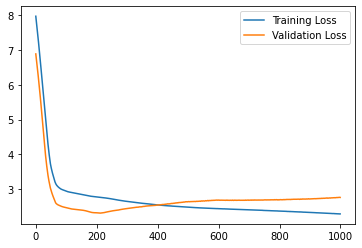

In [ ]:
# # fit network
history = model.fit(train_X, train_y[:,0], epochs=1000, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
print(test_X.shape)
inv_yhat = np.concatenate((yhat, test_X[:,0, 1:]), axis=1)
# Actial Input
inv_xp=inv_yhat[:,1:]
#predicted output
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,0, 1:]), axis=1)
#Actual output
inv_y = inv_y[:,0]
print("Actial Input:")
print(inv_xp)
print("Actual output:")
print(inv_y)
print("Predicted output:")
print(inv_yhat)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(42, 1, 10)
Actial Input:
[[-1.3197203   0.81607056  1.         -1.2826854   0.03780021  1.
  -1.2542353  -1.3217961   1.        ]
 [-1.2826854   0.03780021  1.         -1.2542353  -1.3217961   1.
  -1.366449    2.0425594   1.        ]
 [-1.2542353  -1.3217961   1.         -1.366449    2.0425594   1.
  -1.2710495  -0.5515321   1.        ]
 [-1.366449    2.0425594   1.         -1.2710495  -0.5515321   1.
  -1.3200036   1.0850017   2.        ]
 [-1.2710495  -0.5515321   1.         -1.3200036   1.0850017   2.
  -1.3070874   0.9229534   2.        ]
 [-1.3200036   1.0850017   2.         -1.3070874   0.9229534   2.
  -1.3294923   0.29994014  1.        ]
 [-1.3070874   0.9229534   2.         -1.3294923   0.29994014  1.
  -1.3309097   1.9261391   1.        ]
 [-1.3294923   0.29994014  1.         -1.3309097   1.9261391   1.
  -1.2596173  -1.8930709   1.        ]
 [-1.3309097   1.9261391   1.         -1.2596173  -1.8930709   1.
  -1.3243226  -1.6069025   1.        ]
 [-1.2596173  -1.8930709   1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


Text(0.5, 1.0, 'Sales Projection')

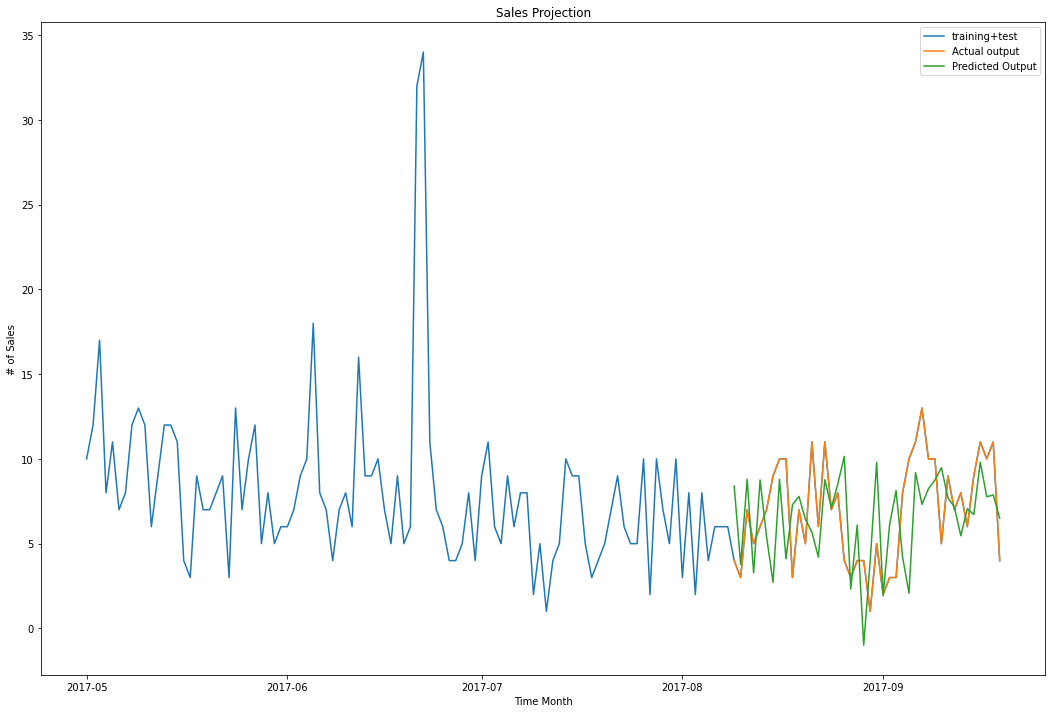

In [177]:
df1=df.drop(['new_entry_year','new_entry_month','DataFrame_Column','week','time_entry_date','signal_type'],axis=1)
df1["day_int"] = [1 if d =='weekday' else 2 for d in df1["day"]]
df1=df1.drop("day",axis=1)
df1.head()
df1["String_Entry_date"]=[x.strftime('%Y %m %d %H:%M:%S') for x in df1["day_entry_date"]]
df1.head()
df1["Entry_date"]=[pd.datetime.strptime(x, '%Y %m %d %H:%M:%S') for x in df1["String_Entry_date"]]
df1.head()

df1=df1[df1["proximity"].isin(["immediate","near"])].loc[:,["vendor_id","subscriber_id","distance","Entry_date","day_int"]]
df2=df1.groupby(["Entry_date"],as_index=False).agg({"subscriber_id":pd.Series.nunique,}).rename(columns = {"subscriber_id":"subscriber_unique"})
df2.head()
df2.index = pd.DatetimeIndex(df2.Entry_date)
df2=df2.drop("Entry_date",axis=1)
test_xaxis=df2.index[100:]
plt.figure(figsize=(18,12))
plt.plot(df2["subscriber_unique"], label='training+test');
plt.plot(test_xaxis,inv_y, label='Actual output')
plt.plot(test_xaxis,inv_yhat, label='Predicted Output')
plt.legend(loc='best')
plt.xlabel('Time Month')
plt.ylabel('# of Sales')
plt.title('Sales Projection')